In [1]:
# import statements
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from astropy.io import fits
from scipy import ndimage
from photutils import centroid_sources, centroid_com, centroid_1dg, centroid_2dg
from astroCalibReduction import *

1. Gather Clio data
2. Outline of reduction script:
3. linearity correction
4. bad pixel correction
5. sky subtraction via nodding pairs
6. coarse registration, then fine registration via IDL

In [2]:
root = os.getcwd()
datadir = 'C:/Users/willi/Dropbox (Amherst College)/Research/Follette-Lab/Thesis-data/William/trapezium_data/'

In [3]:
badpixelpath = datadir + '../Clio2_reduction_files/badpix_fullframe.fit'
badpixelmap = fits.getdata(badpixelpath)

In [4]:
runtheReduction(datadir, badpixelpath)

Max x-shift=138, max y-shift=233 (pixels)

 Done stacking!
putting files in an existing folder.
Max x-shift=28, max y-shift=234 (pixels)

 Done stacking!
putting files in an existing folder.


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\willi\Amherst\Thesis\Code\diskShapers\astroCalib\astroCalibReduction.py:257: RuntimeWarning: Mean of empty slice
  im1_gray -= np.nanmean(im1_gray)
C:\Users\willi\Amherst\Thesis\Code\diskShapers\astroCalib\astroCalibReduction.py:258: RuntimeWarning: Mean of empty slice
  im2_gray -= np.nanmean(im2_gray)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


ValueError: All-NaN slice encountered

In [ ]:
result = fits.getdata()

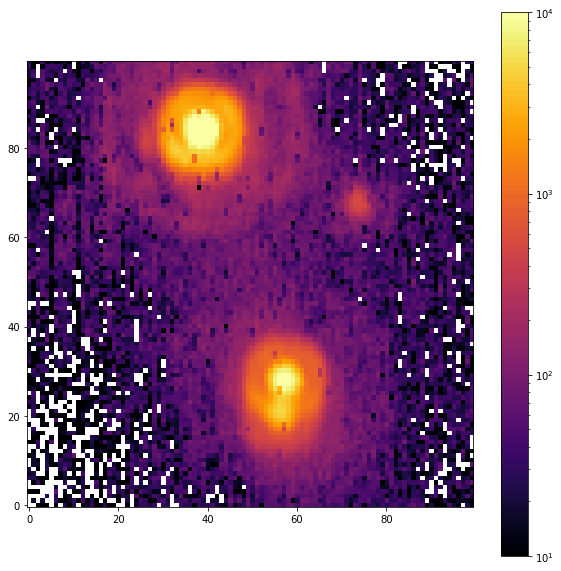

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(result[300:400, 120:220], origin='lower', cmap='inferno', norm=col.LogNorm(vmin=10, vmax=10000))
plt.colorbar()

<ipython-input-10-cfd71ac9dc54>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


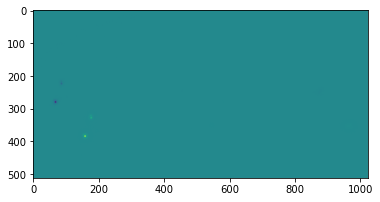

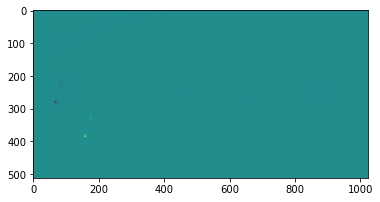

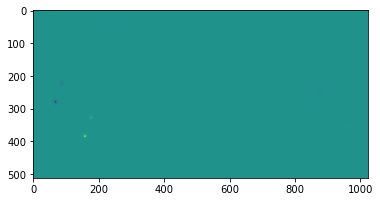

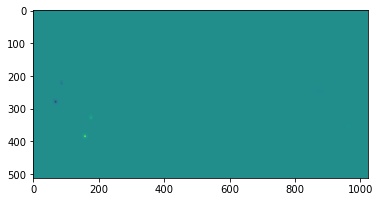

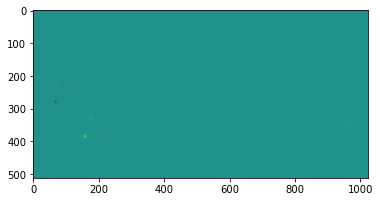

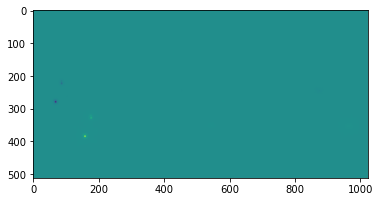

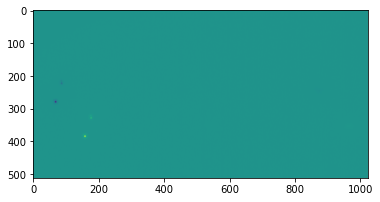

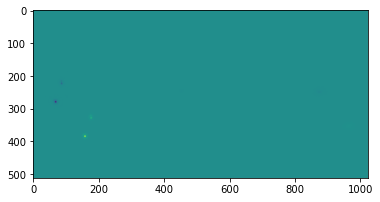

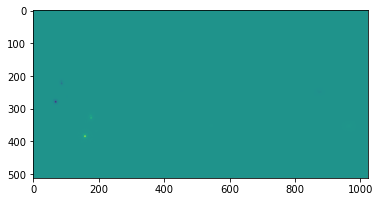

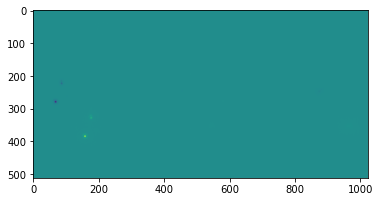

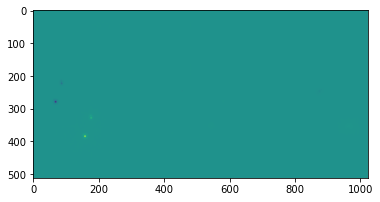

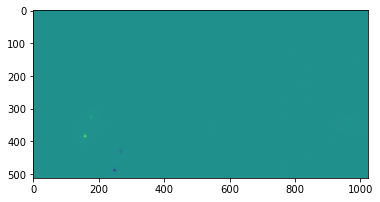

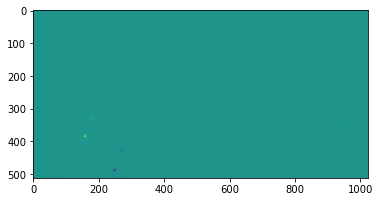

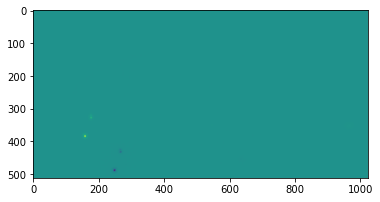

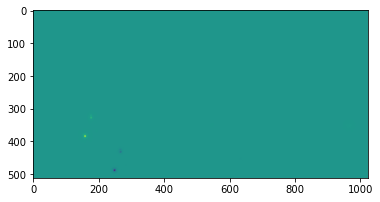

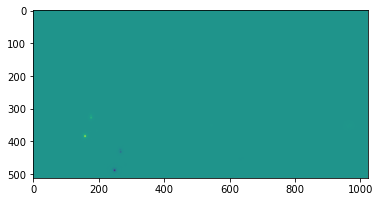

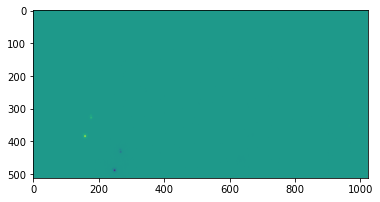

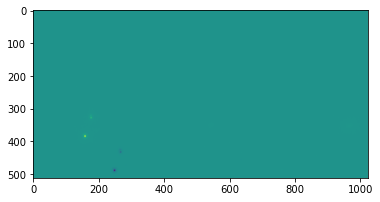

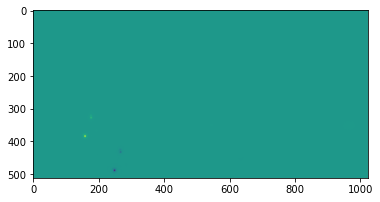

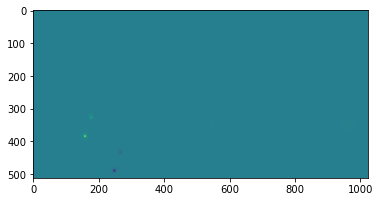

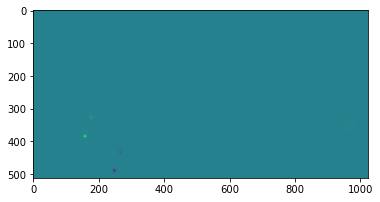

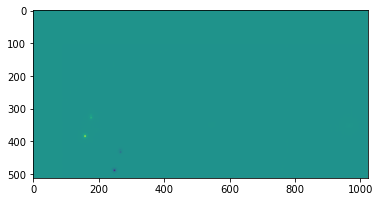

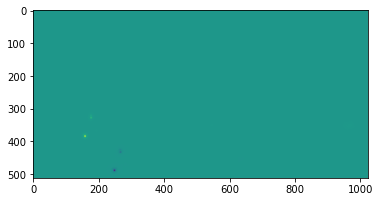

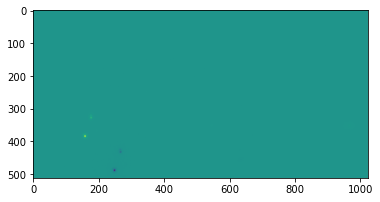

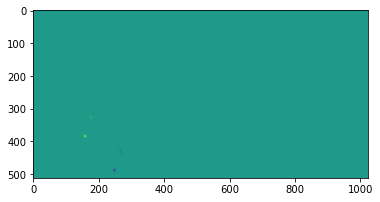

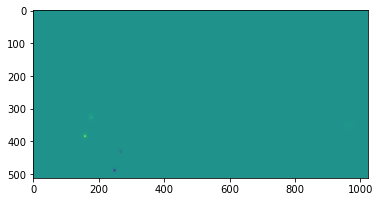

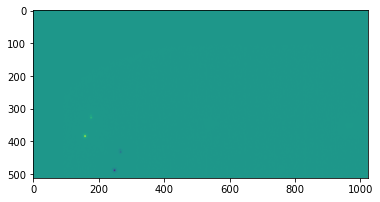

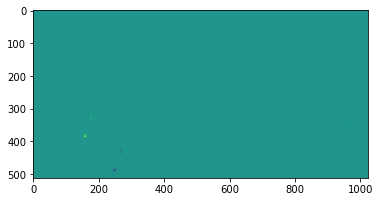

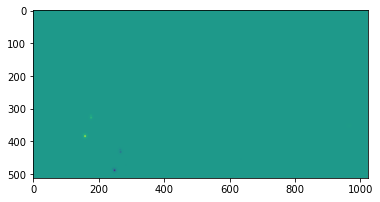

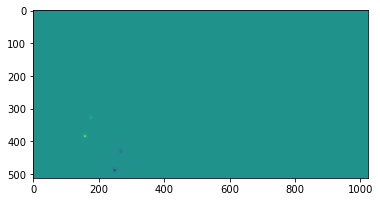

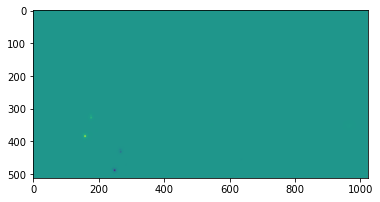

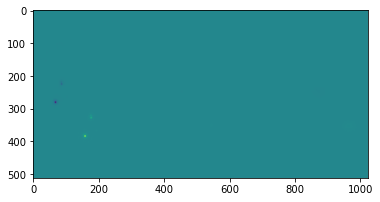

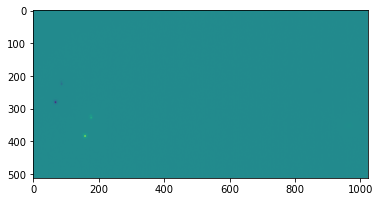

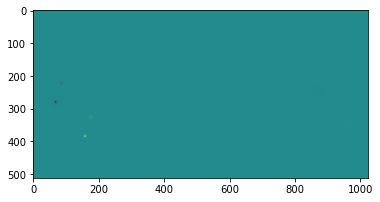

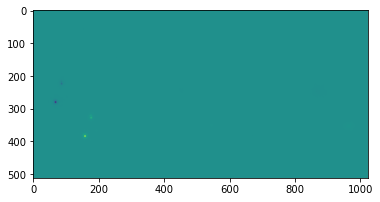

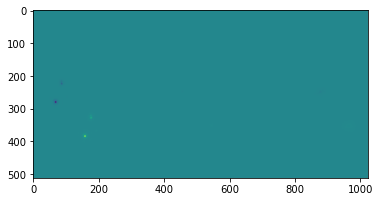

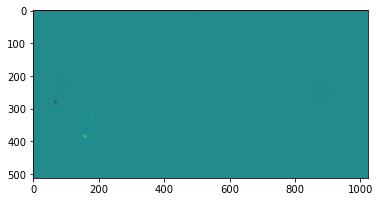

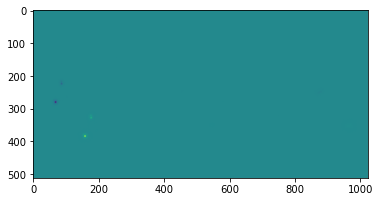

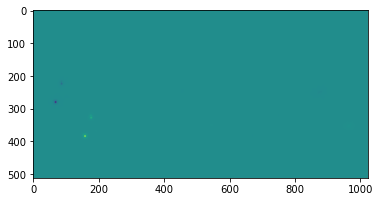

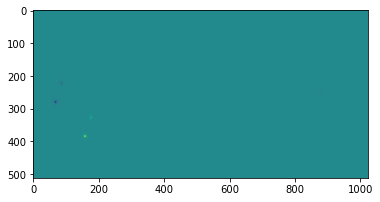

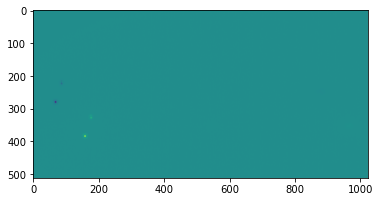

In [10]:
for im in test3:
    plt.figure()
    plt.imshow(im)

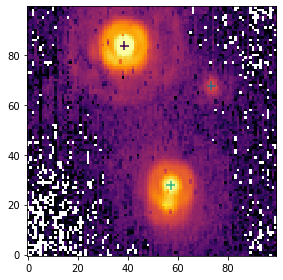

In [49]:
data = test2[300:400, 120:220]
y_init = (80, 70, 25, 5)
x_init = (40, 80, 55, 54)
x, y = centroid_sources(data, x_init, y_init, box_size=15,
                        centroid_func=centroid_2dg)
plt.figure(figsize=(8, 4))
plt.imshow(data, origin='lower', interpolation='nearest', cmap='inferno', norm=col.LogNorm(vmin=10, vmax=10000))
plt.scatter(x, y, marker='+', s=80, c=[0,1,2,3])
plt.tight_layout()